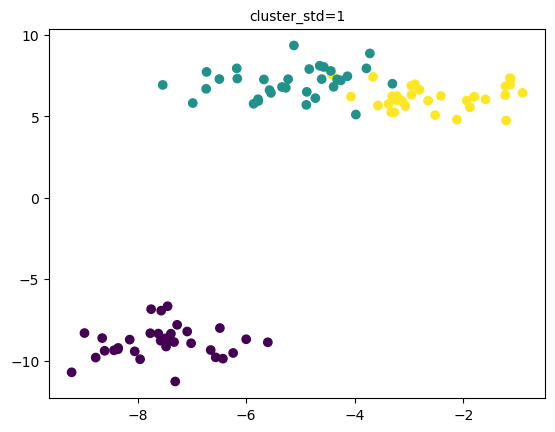

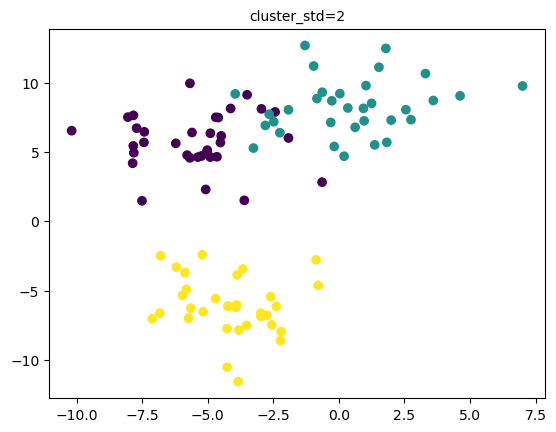

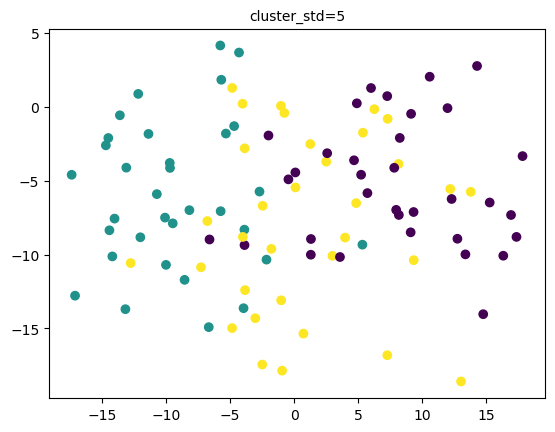

In [41]:
# Create synthetic data for clustering
import sklearn.datasets as data
import matplotlib.pyplot as plt
stdList = [1,2,5]
# Plot examples of synthetic data for varying standard distributions vales
for std in stdList:
    X, clusters = data.make_blobs(n_samples=100,n_features=2,cluster_std=std)
    plt.scatter(X[:, 0], X[:, 1], c=clusters)
    plt.title(f'cluster_std={std}', fontsize = 10)
    plt.show() 

In [42]:
# KMeans implementation
import numpy as np

# Euclidean distance metric
def dist(x,c):
    return np.sqrt(np.sum((x-c)**2))

# KMeans clustering algorithm
def kMeans(k,X,out=False):
    oldLabels = []
    clustLabels = []
    clusterSet = []
    it, nc = 0, -1
    centres = X[np.random.choice(len(X),k),:]
    for c in centres:
        clusterSet.append([np.array(c)])
    while (not (clustLabels == oldLabels) or (it == 0)) and (it<20):
        it+=1
        oldLabels = clustLabels
        clustLabels = []
        for inst in X:
            temp, nc, nm = 1000, -1, 1000
            for i,c in enumerate(centres):
                nm = min(dist(inst,c),nm)
                if temp != nm:
                    nc = i
                    temp = nm
            clusterSet[nc].append(np.array(inst))
            clustLabels.append(nc)
        if (out):
            plt.scatter(X[:, 0], X[:, 1], c=clustLabels)
            plt.title(f'Iteration {it}', fontsize = 10)
            plt.show()
        centres = []
        for c in clusterSet:
            centres.append(np.mean(c,axis=0))
    return clusterSet,clustLabels,centres

In [43]:
# Compute Scores
def computeScore(centres,clusterSet=[],inert=-1):
    score, WC, BC = 0, 0, 0
    if inert!=-1:
        WC = inert
    else:
        for i,C in enumerate(clusterSet):
            for x in C:
                WC += dist(x,centres[i])**2

    for i,ci in enumerate(centres):
        for l,cl in enumerate(centres):
            if (i<l):
                BC += dist(ci,cl)**2

    score = BC/WC
        
    return score, BC, WC

In [44]:
# Generate data
X, clusters = data.make_blobs(n_samples=100,n_features=2,cluster_std=1)
# Example with outputs
clusterSet,clustLabels,centres = kMeans(3,X)
score, BC, WC = computeScore(centres,clusterSet=clusterSet)
print(f'Score: {round(score,4)} = {round(BC,2)}/{round(WC,2)}')

Score: 0.0313 = 282.02/9002.36


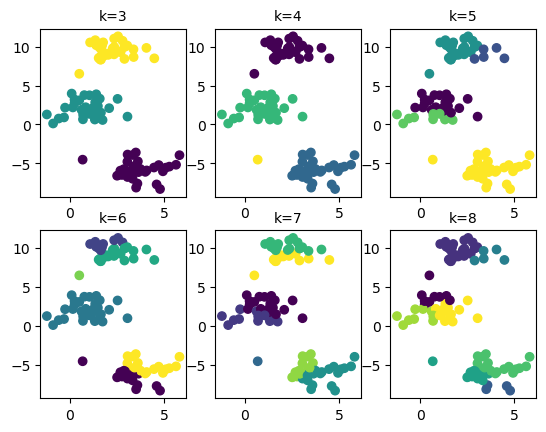

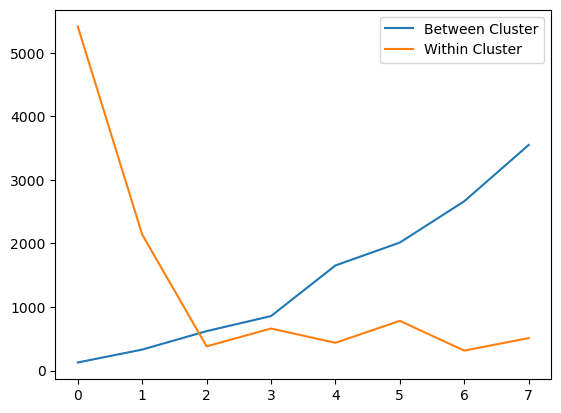

In [45]:
# KMeans clustering from scratch
BCscores=[]
WCscores=[]
toPlot = range(3,9)
for k in range(2,10):
    clusterSet,clustLabels,centres = kMeans(k,X)
    if k in toPlot:
        plt.subplot(2, 3, toPlot.index(k)+1)
        plt.scatter(X[:, 0], X[:, 1], c=clustLabels)
        plt.title(f'k={k}', fontsize = 10)
    score, BC, WC = computeScore(centres,clusterSet=clusterSet)
    BCscores.append(BC)
    WCscores.append(WC)
plt.show()
plt.plot(BCscores, label = 'Between Cluster')
plt.plot(WCscores, label = 'Within Cluster')
plt.legend()
plt.show()

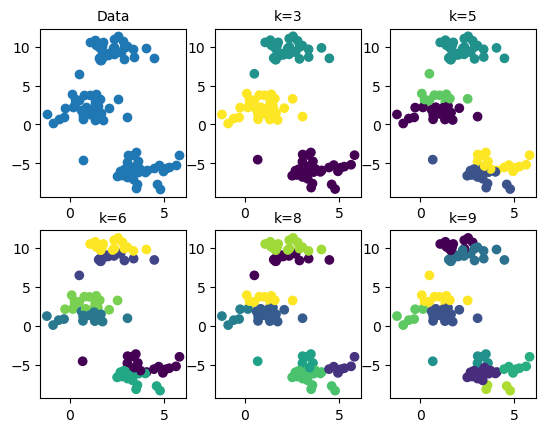

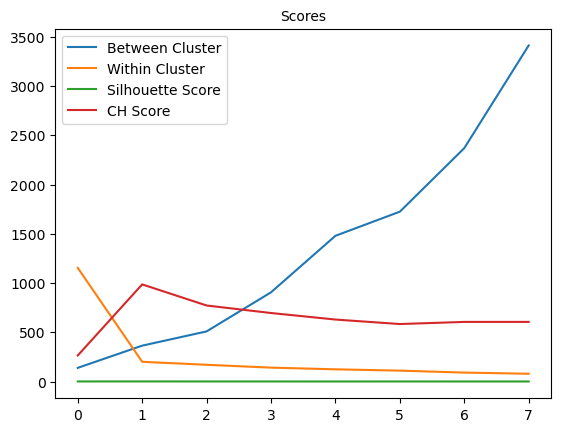

In [46]:
# KMeans clustering using sci-kit
import sklearn.cluster as cluster
import sklearn.metrics as metrics
BCscores=[]
WCscores=[]
SCscores=[]
CHscores=[]
toPlot = [3,5,6,8,9]
plt.subplot(2, 3, 1)
plt.scatter(X[:, 0], X[:, 1])
plt.title(f'Data', fontsize = 10)
for k in range(2,10):
    km = cluster.KMeans(n_clusters=k,n_init=10)
    km.fit(X)
    if k in toPlot:
        plt.subplot(2, 3, toPlot.index(k)+2)
        plt.scatter(X[:, 0], X[:, 1], c=km.labels_)
        plt.title(f'k={k}', fontsize = 10)
    SCscores.append(metrics.silhouette_score(X,km.labels_,metric='euclidean'))
    CHscores.append(metrics.calinski_harabasz_score(X,km.labels_))
    score, BC, WC = computeScore(km.cluster_centers_,inert=km.inertia_)
    BCscores.append(BC)
    WCscores.append(WC)
plt.show()
plt.plot(BCscores, label = 'Between Cluster')
plt.plot(WCscores, label = 'Within Cluster')
plt.plot(SCscores, label = 'Silhouette Score')
plt.plot(CHscores, label = 'CH Score')
plt.legend()
plt.title(f'Scores', fontsize = 10)
plt.show()

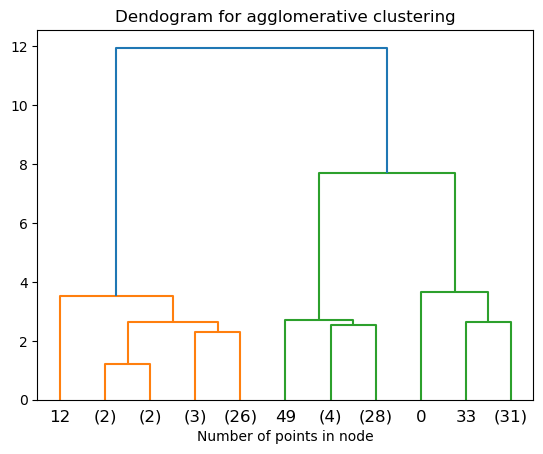

In [47]:
# Agglometrative clustering on data
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

ac = cluster.AgglomerativeClustering(distance_threshold=0,n_clusters=None, linkage='average', metric='euclidean')
ac.fit(X)

plot_dendrogram(ac, truncate_mode="level", p=3)
plt.title("Dendogram for agglomerative clustering")
plt.xlabel("Number of points in node")
plt.show()


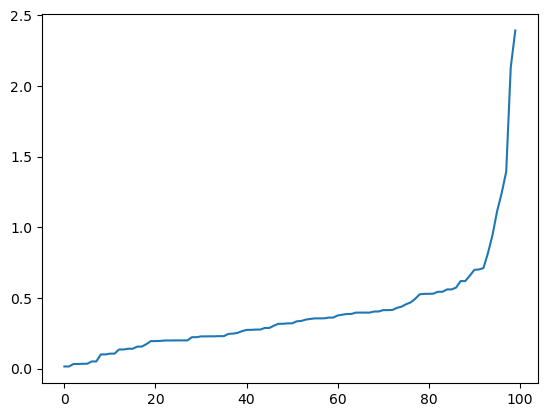

In [62]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=2, metric='euclidean')
nn.fit(X)

dist, ind = nn.kneighbors(X,n_neighbors=2)
dist = np.delete(dist,0,1)

plt.plot(sorted(dist))
plt.show()

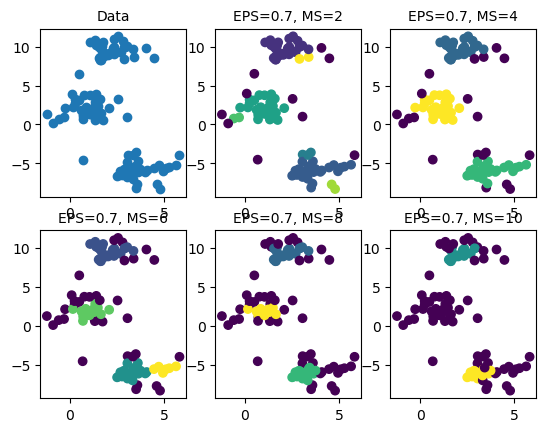

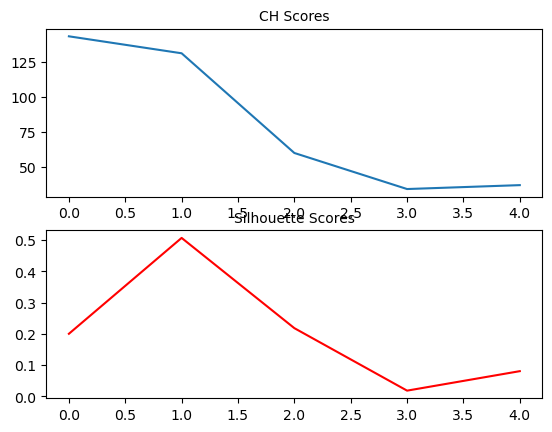

In [59]:
eps = 0.7 # Set epsilon based on KNN plot above
SCscores=[]
CHscores=[]
plt.subplot(2, 3, 1)
plt.scatter(X[:, 0], X[:, 1])
plt.title(f'Data', fontsize = 10)
for k in range(2,12,2):
    db = cluster.DBSCAN(eps=eps, min_samples=int(k))
    db.fit(X)
    plt.subplot(2, 3, int(k/2)+1)
    plt.scatter(X[:, 0], X[:, 1], c=db.labels_)
    plt.title(f'EPS={eps}, MS={k}', fontsize = 10)

    SCscores.append(metrics.silhouette_score(X,db.labels_,metric='euclidean'))
    CHscores.append(metrics.calinski_harabasz_score(X,db.labels_))
plt.show()

plt.subplot(2, 1, 1)
plt.plot(CHscores, label = 'CH Score')
plt.title(f'CH Scores', fontsize = 10)

plt.subplot(2, 1, 2)
plt.plot(SCscores, label = 'Silhouette Score', c='r')
plt.title(f'Silhouette Scores', fontsize = 10)
plt.show()